# Synthetic Data Variable Curve Test

In [2]:
import os

os.chdir(f"/home/{os.getlogin()}/watttime-python-client-aer-algo")

import numpy as np
import pandas as pd
from watttime import WattTimeHistorical, WattTimeForecast
import data.dataset as od
import evaluation.eval_framework as evu
import data.s3 as s3u
import math

import seaborn as sns
import matplotlib.pyplot as plt
import swifter
import pickle

username = os.getenv("WATTTIME_USER")
password = os.getenv("WATTTIME_PASSWORD")

s3 = s3u.s3_utils()
key = "20240726_1k_synth_users_163_days.csv"
generated_data = s3.load_csvdataframe(file=key)

In [2]:
## DON'T RERUN -- LOAD PICKLE FILE BELOW

generated_data.columns =  ['index', 'distinct_dates', 'user_type', 'session_start_time', 'session_end_time',
       'initial_charge', 'total_seconds_to_95', 'full_charge_time',
       'length_plugged_in', 'charged_kWh_actual', 'final_perc_charged',
       'final_charge_time', 'uncharged', 'total_capacity', 'power_output_rate',
       'total_intervals_plugged_in', 'charge_MWh_needed', 'charged_MWh_actual',
       'MWh_fraction']

synth_data = generated_data.sample(100).copy(deep=True)
synth_data["session_start_time"] = pd.to_datetime(synth_data["session_start_time"])

synth_data["length_of_session_in_seconds"] = (
        pd.to_datetime(synth_data.session_end_time) - pd.to_datetime(synth_data.session_start_time)
    ) / pd.Timedelta(seconds=1)

## Calculate Variable MOERs

In [4]:
from evaluation.config import CARS
import evaluation.battery as b

In [5]:
tesla_charging_curve = pd.DataFrame(
        columns=["SoC", "kW"],
        data = CARS['tesla']
    )

In [28]:
# DON'T RERUN -- LOAD PICKLE FILE BELOW 
# 5 minutes for 100 rows
synth_data["variable_power_output_rate"] = synth_data.swifter.apply( 
    lambda x: b.Battery(
        initial_soc = x.initial_charge, 
        charging_curve = tesla_charging_curve,
        capacity_kWh = x.total_capacity
    ).get_usage_power_kw_df(),
    axis=1
    )

Pandas Apply:   0%|          | 0/100 [00:00<?, ?it/s]

## Calculate MOERs

In [29]:
## DON'T RUN -- LOAD PICKLE FILE BELOW
region = "PJM_CHICAGO"

synth_data["moer_data"] = synth_data.apply(
    lambda x: evu.get_historical_fcst_data(
        x.session_start_time, math.ceil(x.total_intervals_plugged_in), region=region
    ),
    axis=1,
)

synth_data["moer_data_actual"] = synth_data.apply( 
    lambda x: evu.get_historical_actual_data(
        x.session_start_time, math.ceil(x.total_intervals_plugged_in), region=region
    ),
    axis=1,
)

## LOAD PICKLE FILE NOW

In [3]:
file = s3.load_file("PJM_CHICAGO_variable_charge_20240928.pkl")
synth_data = pickle.loads(file)

In [32]:
get_charging_schedule_lambda = lambda x: x["usage"].values.flatten()
get_total_emissions_lambda = lambda x: x["emissions_co2e_lb"].sum()

synth_data["optimizer_ideal_sophisticated"] = synth_data.swifter.apply(
    lambda x: evu.get_schedule_and_cost_api(
        usage_power_kw=x.variable_power_output_rate,
        time_needed=int(
            math.ceil(
                min(x.total_seconds_to_95, x.length_of_session_in_seconds) / 300.0
            )
            * 5
        ),
        total_time_horizon=math.ceil(x.total_intervals_plugged_in),
        moer_data=x.moer_data_actual,
        optimization_method="auto",
    ),
    axis=1,
)

synth_data["sophisticated_ideal_charging_schedule"] = synth_data[
    "optimizer_ideal_sophisticated"
].apply(get_charging_schedule_lambda)
synth_data["sophisticated_ideal_emissions"] = synth_data["optimizer_ideal_sophisticated"].apply(
    get_total_emissions_lambda
)

Pandas Apply:   0%|          | 0/100 [00:00<?, ?it/s]

== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==


In [17]:
np.array(synth_data.head(1).optimizer_sophisticated).flatten()

array([                           pred_moer  usage  emissions_co2e_lb  \
       point_time
       2024-02-12 02:50:00+00:00     1226.5    0.0           0.000000
       2024-02-12 02:55:00+00:00     1226.5    0.0           0.000000
       2024-02-12 03:00:00+00:00     1223.8    0.0           0.000000
       2024-02-12 03:05:00+00:00     1223.0    0.0           0.000000
       2024-02-12 03:10:00+00:00     1221.4    0.0           0.000000
       ...                              ...    ...                ...
       2024-02-12 08:05:00+00:00     1164.5    5.0           1.067623
       2024-02-12 08:10:00+00:00     1164.4    5.0           1.067532
       2024-02-12 08:15:00+00:00     1164.8    5.0           1.067898
       2024-02-12 08:20:00+00:00     1164.6    5.0           1.067715
       2024-02-12 08:25:00+00:00     1164.6    5.0           1.067715

                                  energy_usage_mwh
       point_time
       2024-02-12 02:50:00+00:00          0.000000
       2024-02-12 

In [52]:
synth_data = synth_data[synth_data.distinct_dates != '2023-09-26']

In [54]:
synth_data["optimizer_simple"] = synth_data.apply(
    lambda x: evu.get_schedule_and_cost_api(
        usage_power_kw=150,
        time_needed=int(
            math.ceil(
                min(x.total_seconds_to_95, x.length_of_session_in_seconds) / 300.0
            )
            * 5
        ),
        total_time_horizon=math.ceil(x.total_intervals_plugged_in),
        moer_data=x.moer_data,
        optimization_method="auto",
    ),
    axis=1,
)

synth_data["optimizer_simple_schedule"] = synth_data["optimizer_simple"].apply(
    get_charging_schedule_lambda
)

synth_data["optimizer_simple_estimated_emissions"] = synth_data[
    "optimizer_simple"
].apply(get_total_emissions_lambda)
synth_data["optimizer_simple_actual_emissions"] = synth_data.apply(
    lambda x: evu.get_total_emission(
        x.moer_data_actual["value"],
        x.optimizer_simple.energy_usage_mwh,
    ),
    axis=1
)

== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple 

/tmp/ipykernel_1877778/3052620817.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  synth_data["optimizer_simple"] = synth_data.apply(
/tmp/ipykernel_1877778/3052620817.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  synth_data["optimizer_simple_schedule"] = synth_data["optimizer_simple"].apply(
/tmp/ipykernel_1877778/3052620817.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

In [55]:
synth_data["optimizer_sophisticated"] = synth_data.apply(
    lambda x: evu.get_schedule_and_cost_api(
        usage_power_kw=x.variable_power_output_rate,
        time_needed=int(
            math.ceil(
                min(x.total_seconds_to_95, x.length_of_session_in_seconds) / 300.0
            )
            * 5
        ),
        total_time_horizon=math.ceil(x.total_intervals_plugged_in),
        moer_data=x.moer_data,
        optimization_method="auto",
    ),
    axis=1,
)

synth_data["optimizer_sophisticated_schedule"] = synth_data["optimizer_sophisticated"].apply(
    get_charging_schedule_lambda
)
synth_data["optimizer_sophisticated_estimated_emissions"] = synth_data[
    "optimizer_sophisticated"
].apply(get_total_emissions_lambda)
synth_data["optimizer_sophisticated_actual_emissions"] = synth_data.apply(
    lambda x: evu.get_total_emission(
        x.moer_data_actual["value"],
        x.optimizer_sophisticated.energy_usage_mwh,
    ),
    axis=1,
)

== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==


In [56]:
synth_data["optimizer_baseline"] = synth_data.apply(
    lambda x: evu.get_schedule_and_cost_api(
        usage_power_kw=x.variable_power_output_rate,
        time_needed=int(
            math.ceil(
                min(x.total_seconds_to_95, x.length_of_session_in_seconds) / 300.0
            )
            * 5
        ),
        total_time_horizon=math.ceil(x.total_intervals_plugged_in),
        moer_data=x.moer_data,
        optimization_method="baseline",
    ),
    axis=1,
)

synth_data["optimizer_baseline_schedule"] = synth_data["optimizer_baseline"].apply(
    get_charging_schedule_lambda
)
synth_data["optimizer_baseline_estimated_emissions"] = synth_data[
    "optimizer_baseline"
].apply(get_total_emissions_lambda)
synth_data["optimizer_baseline_actual_emissions"] = synth_data.apply(
    lambda x: evu.get_total_emission(
        x.moer_data_actual["value"],
        x.optimizer_baseline.energy_usage_mwh,
    ),
    axis=1,
)

== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==


In [58]:
pkl = pickle.dumps(synth_data)
s3.store_dictionary(dictionary=pkl, file=f"{region}_variable_charge_20240928.pkl")

Successful S3 put_object response. Status - 200


## Assessment

1. How confidencea are we that the charging + emissions lambda functions work as expected?
2. Sequence matcher to confirm is a different charging schedule is produced.
3. Hypothesis test: The charging schedule generated by the simple optimizer, where the power rate is fixed at the average, is the same, on average, as the charging scheduled generated with the DP algo + variable power curve.
    - TODO: To perform this test, you need to match the simple charging schedule with the variable charging curve

In [30]:
from difflib import SequenceMatcher

In [31]:
ratio_list = []
for index, row in synth_data.iterrows():
    ratio = SequenceMatcher(None, row["optimizer_simple_schedule"], row["optimizer_sophisticated_schedule"]).ratio()
    ratio_list.append(ratio)


In [33]:
synth_data["schedule_diff_ratio"] = ratio_list

<Axes: xlabel='schedule_diff_ratio', ylabel='Count'>

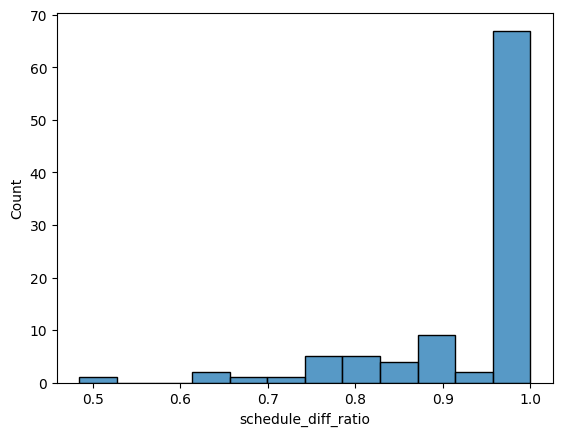

In [34]:
sns.histplot(synth_data["schedule_diff_ratio"])

<Axes: xlabel='distinct_dates'>

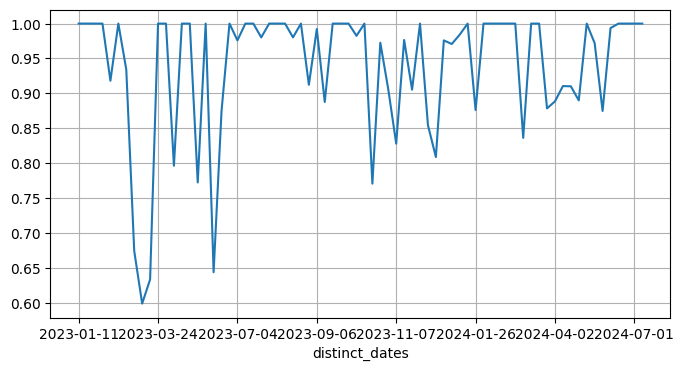

In [35]:
synth_data.groupby(["distinct_dates"])["schedule_diff_ratio"].median().plot(grid=True, figsize=(8, 4))

<Axes: xlabel='distinct_dates'>

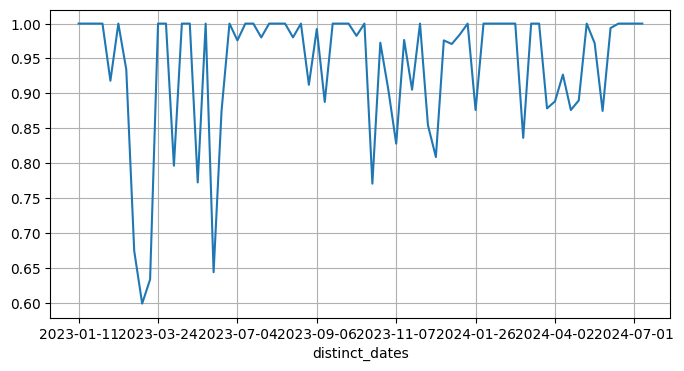

In [36]:
synth_data.groupby(["distinct_dates"])["schedule_diff_ratio"].mean().plot(grid=True, figsize=(8, 4))

<Axes: xlabel='baseline_difference', ylabel='Count'>

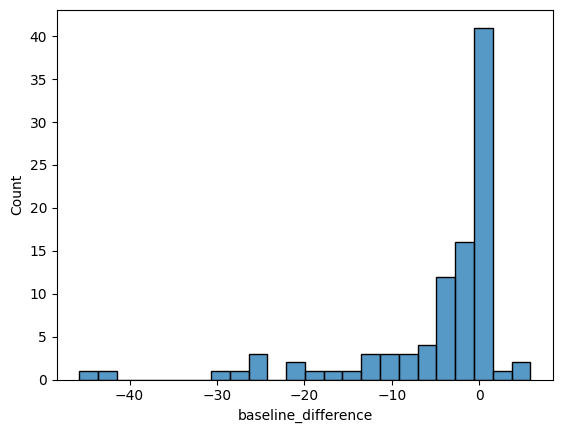

In [41]:
sns.histplot(synth_data["baseline_difference"])

<Axes: xlabel='optimizer_sophisticated_actual_emissions', ylabel='Count'>

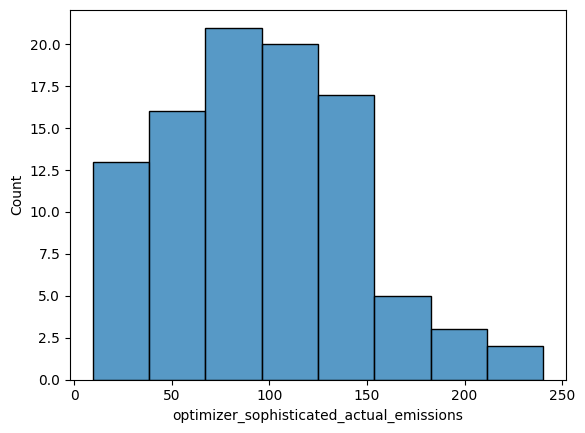

In [38]:
sns.histplot(synth_data["optimizer_sophisticated_actual_emissions"])

<Axes: xlabel='distinct_dates'>

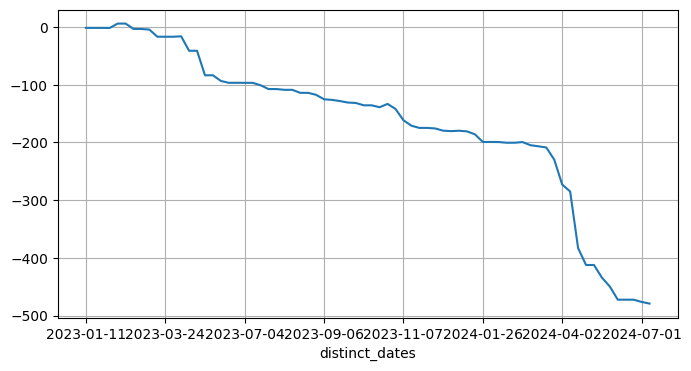

In [42]:
# downward trend despite some issues re: forecast error
synth_data.groupby(["distinct_dates"])["baseline_difference"].sum().cumsum().plot(grid=True, figsize=(8, 4))